In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import dataset

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
root_path = os.getcwd()
data_root = os.path.join(root_path, "data")
model_root = os.path.join(root_path, "model")

In [3]:
df = pd.read_csv(os.path.join(data_root, "Covid_Data.csv"))
df.head(10)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,...,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,...,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,...,2,2,2,2,2,2,2,2,3,2


# Preprocess Data and Handle Missing Values

In [4]:
# Preprocessing the columns, checking for invalid entries in categorical columns
for col in df.columns:
    if col in ["DATE_DIED", "AGE"]:
        continue
    print("Column: {}".format(col))
    print("Unique values:", df[col].unique(), "\n")

Column: USMER
Unique values: [2 1] 

Column: MEDICAL_UNIT
Unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] 

Column: SEX
Unique values: [1 2] 

Column: PATIENT_TYPE
Unique values: [1 2] 

Column: INTUBED
Unique values: [97  1  2 99] 

Column: PNEUMONIA
Unique values: [ 1  2 99] 

Column: PREGNANT
Unique values: [ 2 97 98  1] 

Column: DIABETES
Unique values: [ 2  1 98] 

Column: COPD
Unique values: [ 2  1 98] 

Column: ASTHMA
Unique values: [ 2  1 98] 

Column: INMSUPR
Unique values: [ 2  1 98] 

Column: HIPERTENSION
Unique values: [ 1  2 98] 

Column: OTHER_DISEASE
Unique values: [ 2  1 98] 

Column: CARDIOVASCULAR
Unique values: [ 2  1 98] 

Column: OBESITY
Unique values: [ 2  1 98] 

Column: RENAL_CHRONIC
Unique values: [ 2  1 98] 

Column: TOBACCO
Unique values: [ 2  1 98] 

Column: CLASIFFICATION_FINAL
Unique values: [3 5 7 6 1 2 4] 

Column: ICU
Unique values: [97  2  1 99] 



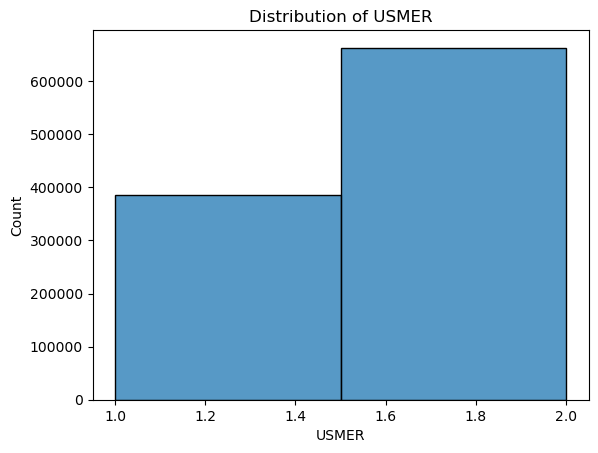

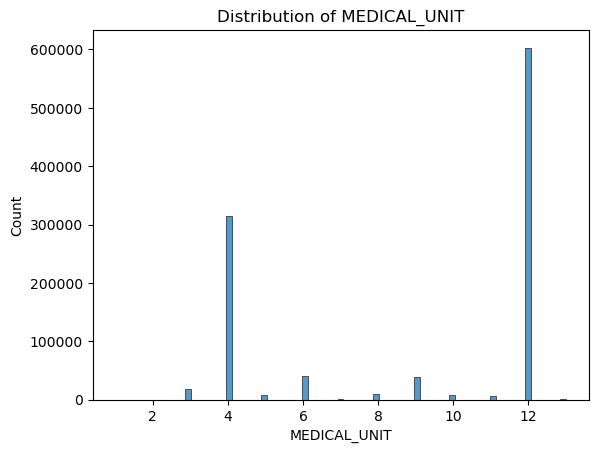

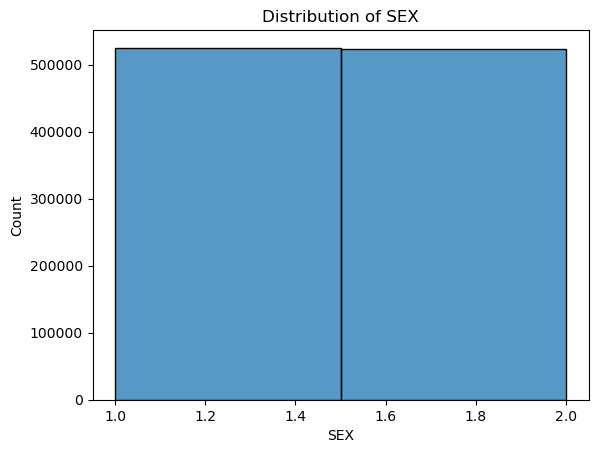

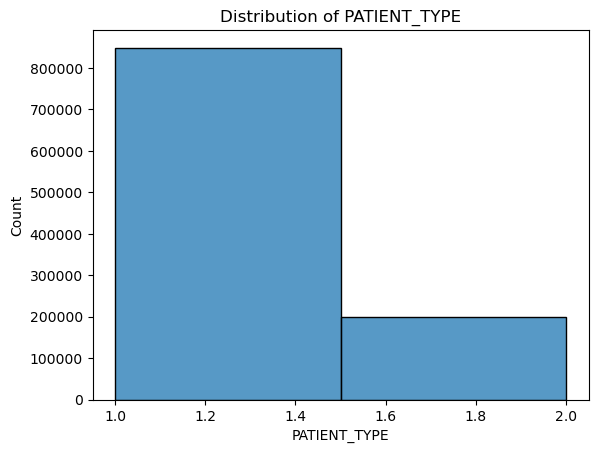

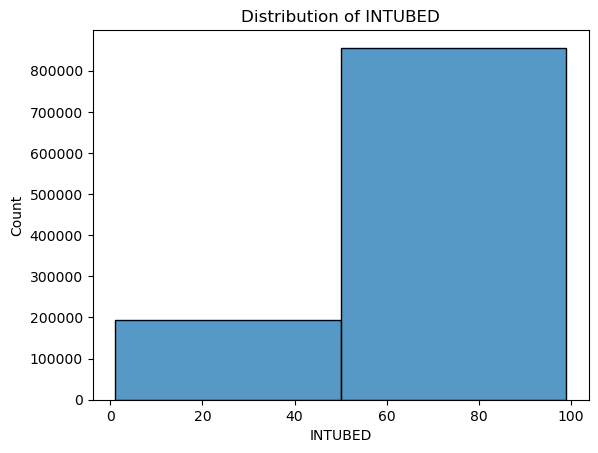

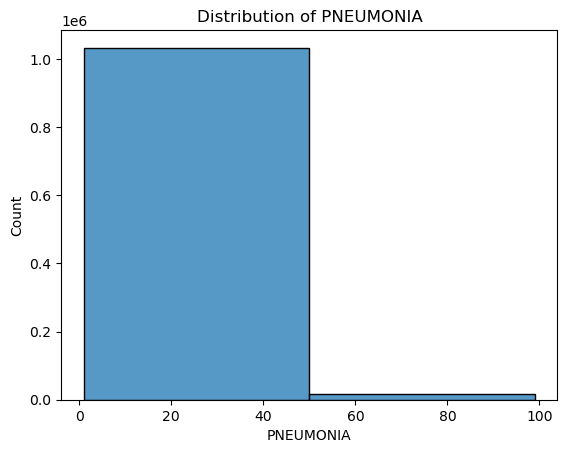

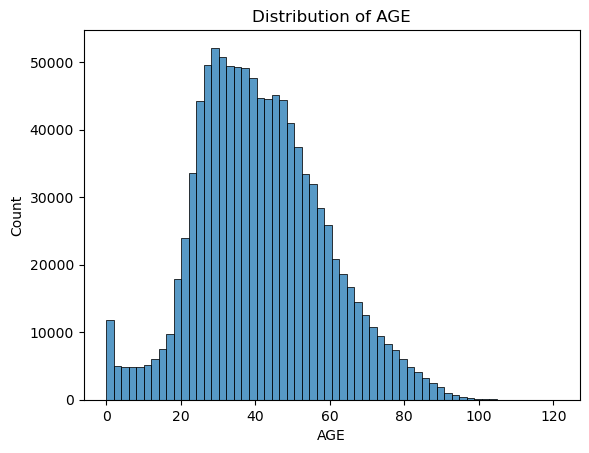

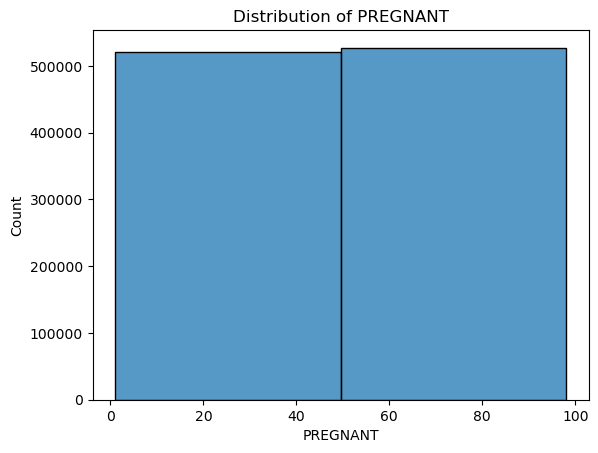

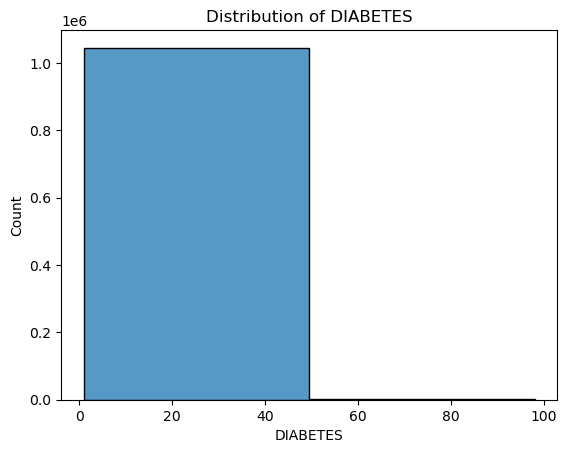

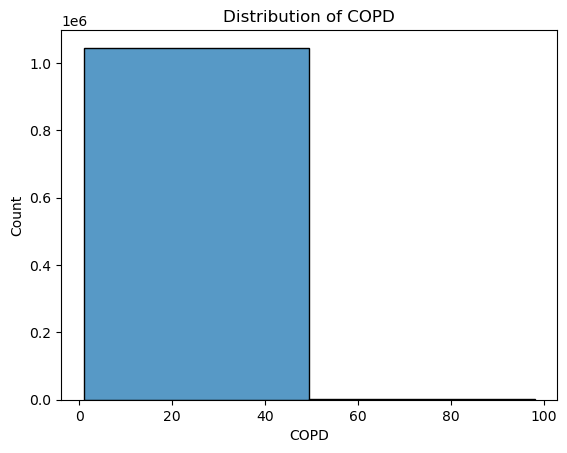

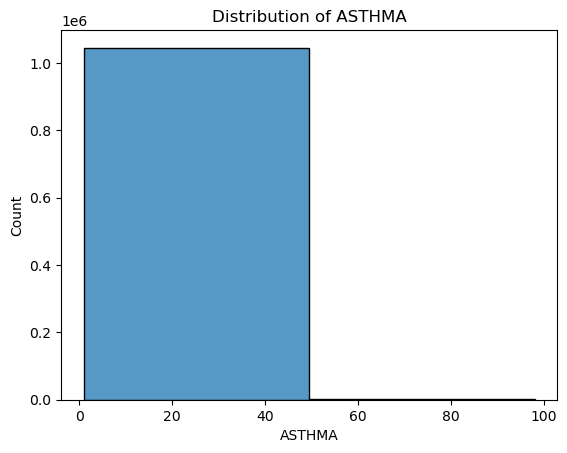

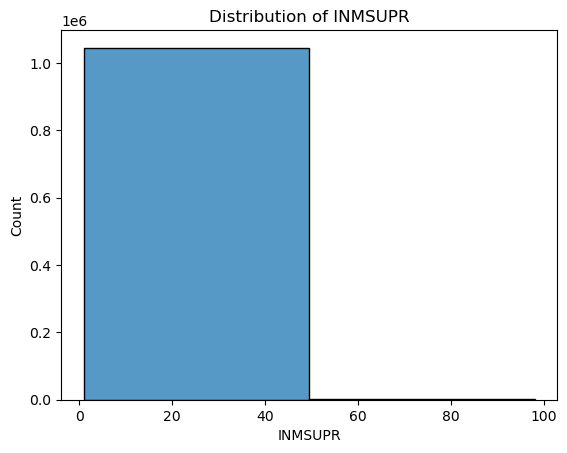

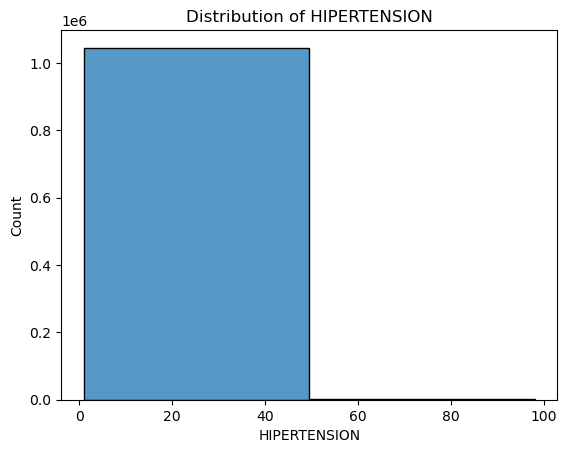

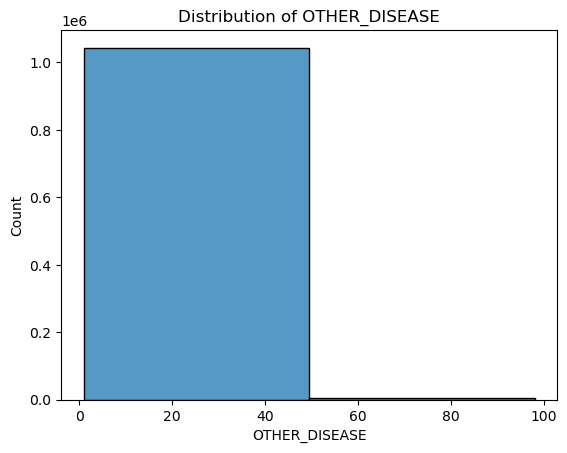

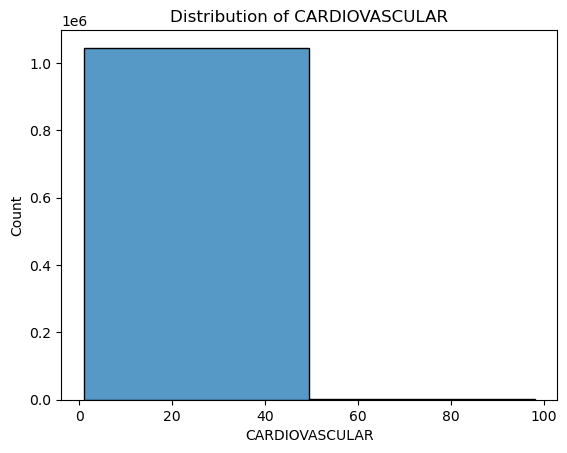

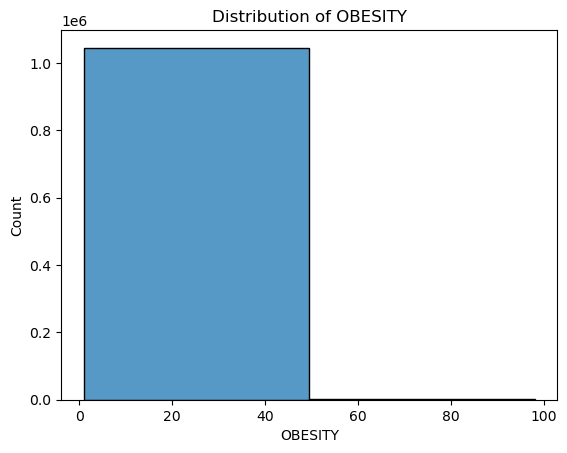

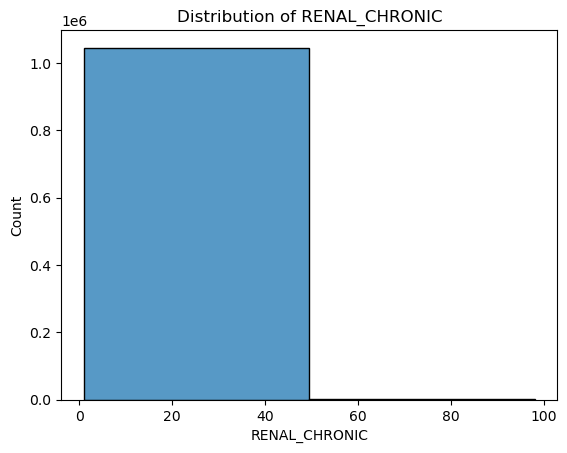

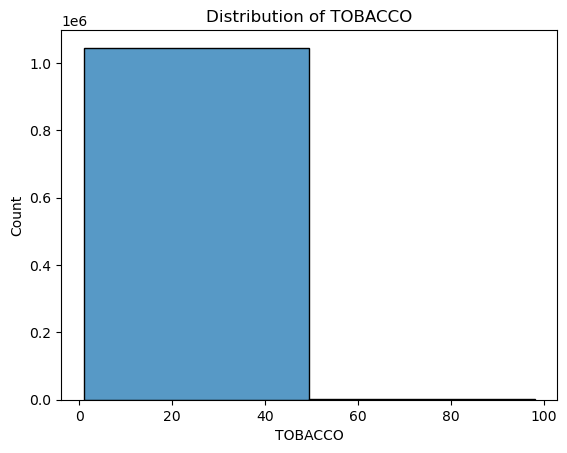

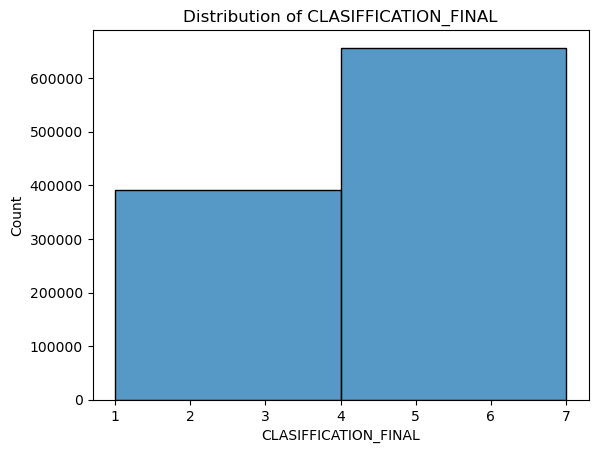

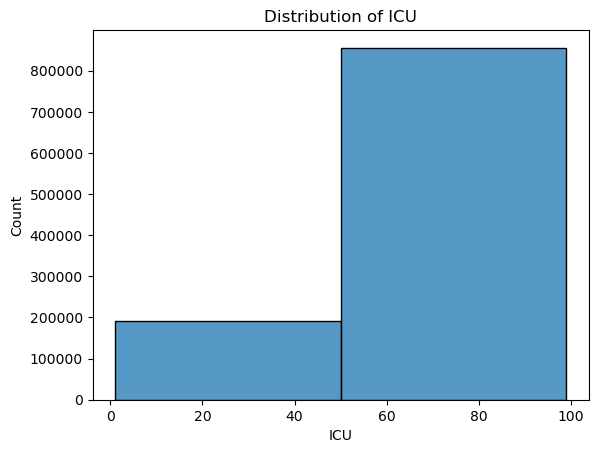

In [5]:
# Plot distribution of features before preprocessing 
for col in df.columns:
    if col=="TARGET_DOA" or col=="DATE_DIED":
        continue
    elif col=="AGE":
        sns.histplot(data=df, x=col, bins=60).set(title='Distribution of ' + str(col))
    elif col=="CLASSIFICATION_FINAL" or col=="MEDICAL_UNIT":
        sns.histplot(data=df, x=col).set(title='Distribution of ' + str(col))
    else:
        sns.histplot(data=df, x=col, bins=2).set(title='Distribution of ' + str(col))
    plt.show()

In [6]:
# Replace invalid or missing values with np.nan
invalid_vals = [97, 98, 99]
categorical_columns = ["USMER", "MEDICAL_UNIT", "SEX", "PATIENT_TYPE", "INTUBED", "PNEUMONIA", "PREGNANT", "DIABETES",
                       "COPD", "ASTHMA", "INMSUPR", 
                       "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC",
                       "TOBACCO", "CLASIFFICATION_FINAL", "ICU"]
for col in categorical_columns:
    df[col].replace(invalid_vals, np.nan, inplace=True)

In [7]:
# Adding a binary column to label target dead or alive
# 0 = alive, 1 = dead
def map_date_to_target(x):
    if str(x) == "9999-99-99":
        return 0
    return 1

df["TARGET_DOA"] = df["DATE_DIED"].apply(map_date_to_target)

df[["DATE_DIED", "TARGET_DOA"]].head(n=20)

,DATE_DIED,TARGET_DOA
0,03/05/2020,1
1,03/06/2020,1
2,09/06/2020,1
3,12/06/2020,1
4,21/06/2020,1
5,9999-99-99,0
6,9999-99-99,0
7,9999-99-99,0
8,9999-99-99,0
9,9999-99-99,0


In [8]:
df=df.drop(columns=['DATE_DIED'])

0    0.926622
1    0.073378
Name: TARGET_DOA, dtype: float64


Text(0.5, 0, 'Target Labels')

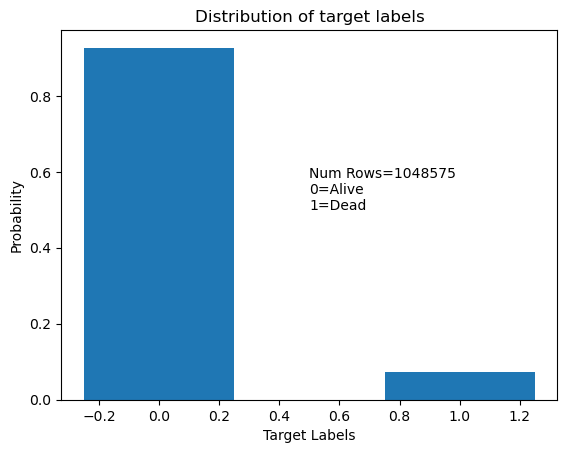

In [9]:
# Plot the distribution of labels
nrows = len(df.index)
ncols = len(df.columns)
df_labels_count = df["TARGET_DOA"].value_counts(normalize=True)
print(df_labels_count)
plt.title("Distribution of target labels")
plt.text(0.5, 0.5, "Num Rows={:d}\n0=Alive\n1=Dead".format(nrows))
plt.bar(df_labels_count.index, df_labels_count, width=0.5)
plt.ylabel("Probability")
plt.xlabel("Target Labels")

In [10]:
# Check the number of rows with empty data
num_nan_rows = df.isnull().any(axis=1).sum()
print("Number of rows with nan: {:d}".format(num_nan_rows))
print("Percentage of rows with nan: {:f}".format(num_nan_rows/nrows))
# Dropping rows with nan is not a viable strategy (over 90% of the rows have nan)

Number of rows with nan: 971743
Percentage of rows with nan: 0.926727


In [11]:
# Check the number of columns with empty data
num_nan_cols = df.isnull().any(axis=0).sum()
print("Number of columns with nan: {:d}".format(num_nan_cols))
print("Percentage of cols with nan: {:f}".format(num_nan_cols/ncols))
# Dropping cols with nan also might not be a good idea (roughly over half the columns have nans). 
# But this is better than dropping the rows with nan, can be used as a baseline if necessary.

# Show columns with nan
print("Columns with nan:", df.columns[df.isnull().any(axis=0)].tolist())

Number of columns with nan: 14
Percentage of cols with nan: 0.666667
Columns with nan: ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']


In [12]:
# Plot percentage of nans in each column
nan_percent = df.isnull().sum()/len(df)
print(nan_percent)

USMER                   0.000000
MEDICAL_UNIT            0.000000
SEX                     0.000000
PATIENT_TYPE            0.000000
INTUBED                 0.816221
PNEUMONIA               0.015262
AGE                     0.000000
PREGNANT                0.502840
DIABETES                0.003183
COPD                    0.002864
ASTHMA                  0.002841
INMSUPR                 0.003246
HIPERTENSION            0.002960
OTHER_DISEASE           0.004811
CARDIOVASCULAR          0.002934
OBESITY                 0.002892
RENAL_CHRONIC           0.002867
TOBACCO                 0.003071
CLASIFFICATION_FINAL    0.000000
ICU                     0.816377
TARGET_DOA              0.000000
dtype: float64


In [13]:
print("Original shape: " + str(df.shape))

Original shape: (1048575, 21)


In [14]:
# Drop the INTUBED, PREGNANT, and ICU columns because they have over 50% missing values
df = df.drop(columns=["INTUBED", "PREGNANT", "ICU"])

In [15]:
# Now check number of rows with na after dropping > 50% missing value columns
num_nan_rows = df.isnull().any(axis=1).sum()
print("Number of rows with nan: {:d}".format(num_nan_rows))
print("Percentage of rows with nan: {:f}".format(num_nan_rows/nrows))

Number of rows with nan: 23423
Percentage of rows with nan: 0.022338


In [16]:
# After removing the 3 columns >50% missing values, we now only have 2% of the rows with missing values. As baseline, drop
# the rows with missing values.

In [17]:
# Now drop the rows with missing values and print the new shape of the dataframe
df = df.dropna()
print("Shape after dropping: " + str(df.shape))

Shape after dropping: (1025152, 18)


0    0.927119
1    0.072881
Name: TARGET_DOA, dtype: float64


Text(0.5, 0, 'Target Labels')

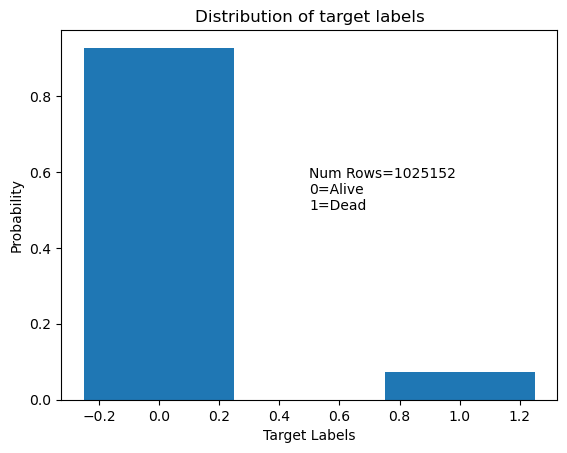

In [18]:
# Now plot the distribution of labels again for sanity check
# Plot the distribution of labels
nrows = len(df.index)
ncols = len(df.columns)
df_labels_count = df["TARGET_DOA"].value_counts(normalize=True)
print(df_labels_count)
plt.title("Distribution of target labels")
plt.text(0.5, 0.5, "Num Rows={:d}\n0=Alive\n1=Dead".format(nrows))
plt.bar(df_labels_count.index, df_labels_count, width=0.5)
plt.ylabel("Probability")
plt.xlabel("Target Labels")

# As you can see, nothing much has changed in the distribution post dropping rows with na values. 
# Alive to Dead = 0.927 to 0.073

In [19]:
# Check the unique column values now
for col in df.columns:
    if col in ["DATE_DIED", "AGE"]:
        continue
    print("Column: {}".format(col))
    print("Unique values:", df[col].unique(), "\n")

Column: USMER
Unique values: [2 1] 

Column: MEDICAL_UNIT
Unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] 

Column: SEX
Unique values: [1 2] 

Column: PATIENT_TYPE
Unique values: [1 2] 

Column: PNEUMONIA
Unique values: [1. 2.] 

Column: DIABETES
Unique values: [2. 1.] 

Column: COPD
Unique values: [2. 1.] 

Column: ASTHMA
Unique values: [2. 1.] 

Column: INMSUPR
Unique values: [2. 1.] 

Column: HIPERTENSION
Unique values: [1. 2.] 

Column: OTHER_DISEASE
Unique values: [2. 1.] 

Column: CARDIOVASCULAR
Unique values: [2. 1.] 

Column: OBESITY
Unique values: [2. 1.] 

Column: RENAL_CHRONIC
Unique values: [2. 1.] 

Column: TOBACCO
Unique values: [2. 1.] 

Column: CLASIFFICATION_FINAL
Unique values: [3 5 7 6 1 2 4] 

Column: TARGET_DOA
Unique values: [1 0] 



In [20]:
# Now the invalid values are gone, but we need to change the 2 to a 0 in binary columns
cols = ["USMER", "SEX", "PATIENT_TYPE", "PNEUMONIA", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION",
        "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO"]
for col in cols:
    df[col] = df[col].replace(2, 0)

for col in df.columns:
    if col in ["DATE_DIED", "AGE"]:
        continue
    print("Column: {}".format(col))
    print("Unique values:", df[col].unique(), "\n")

Column: USMER
Unique values: [0 1] 

Column: MEDICAL_UNIT
Unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] 

Column: SEX
Unique values: [1 0] 

Column: PATIENT_TYPE
Unique values: [1 0] 

Column: PNEUMONIA
Unique values: [1. 0.] 

Column: DIABETES
Unique values: [0. 1.] 

Column: COPD
Unique values: [0. 1.] 

Column: ASTHMA
Unique values: [0. 1.] 

Column: INMSUPR
Unique values: [0. 1.] 

Column: HIPERTENSION
Unique values: [1. 0.] 

Column: OTHER_DISEASE
Unique values: [0. 1.] 

Column: CARDIOVASCULAR
Unique values: [0. 1.] 

Column: OBESITY
Unique values: [0. 1.] 

Column: RENAL_CHRONIC
Unique values: [0. 1.] 

Column: TOBACCO
Unique values: [0. 1.] 

Column: CLASIFFICATION_FINAL
Unique values: [3 5 7 6 1 2 4] 

Column: TARGET_DOA
Unique values: [1 0] 



# Understand Distribution of Features

In [21]:
# Display some metrics for each feature
df.describe().T

,count,mean,std,min,25%,50%,75%,max
USMER,1025152.0,0.357895,0.479381,0.0,0.0,0.0,1.0,1.0
MEDICAL_UNIT,1025152.0,8.993643,3.722439,1.0,4.0,12.0,12.0,13.0
SEX,1025152.0,0.500624,0.500000,0.0,0.0,1.0,1.0,1.0
PATIENT_TYPE,1025152.0,0.812809,0.390065,0.0,1.0,1.0,1.0,1.0
PNEUMONIA,1025152.0,0.134223,0.340892,0.0,0.0,0.0,0.0,1.0
AGE,1025152.0,41.887782,16.748327,0.0,30.0,40.0,53.0,121.0
DIABETES,1025152.0,0.119412,0.324272,0.0,0.0,0.0,0.0,1.0
COPD,1025152.0,0.014023,0.117587,0.0,0.0,0.0,0.0,1.0
ASTHMA,1025152.0,0.029749,0.169893,0.0,0.0,0.0,0.0,1.0
INMSUPR,1025152.0,0.013255,0.114363,0.0,0.0,0.0,0.0,1.0


[Text(0.5, 1.0, 'Distribution of Age')]

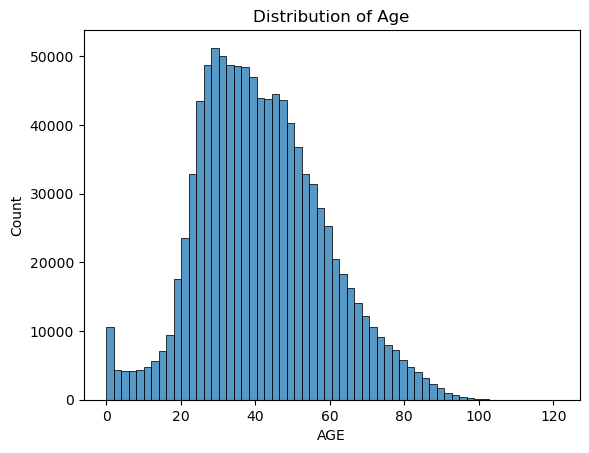

In [22]:
# Plot histogram for age
sns.histplot(data=df, x="AGE", bins=60).set(title='Distribution of Age')

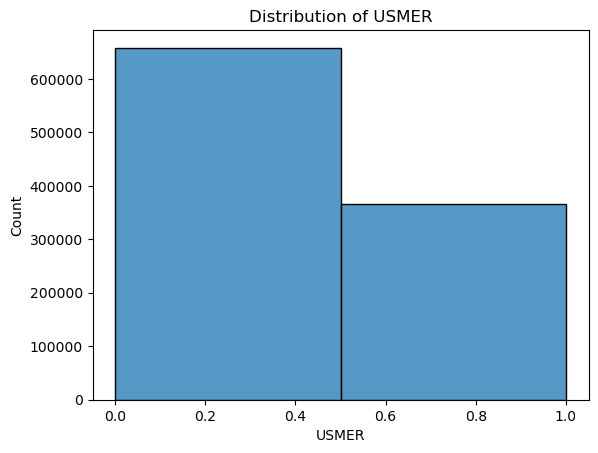

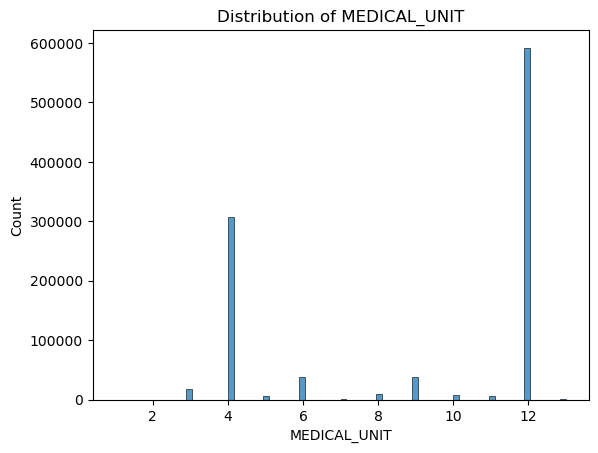

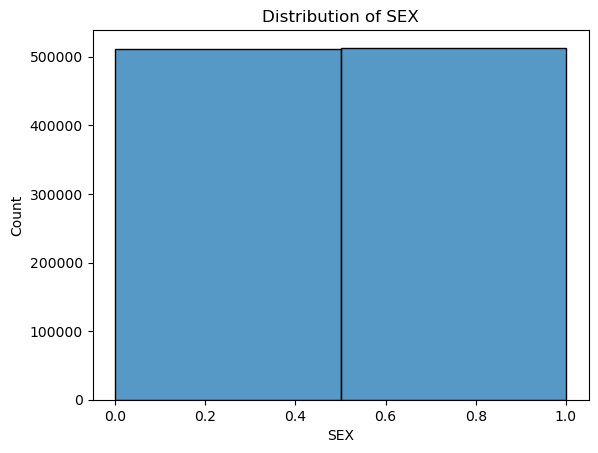

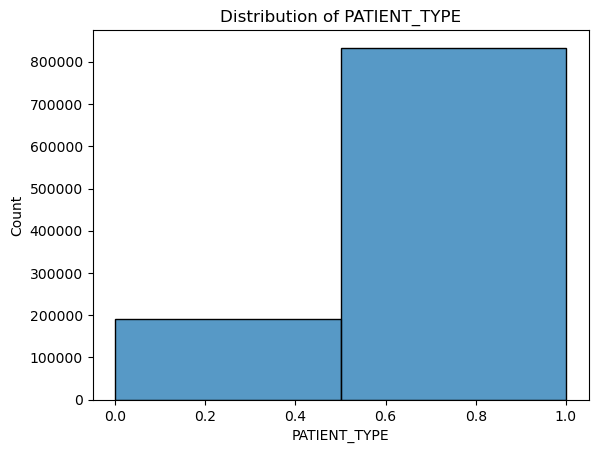

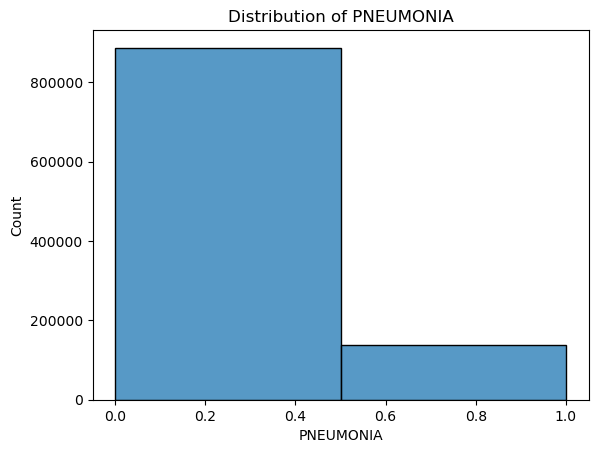

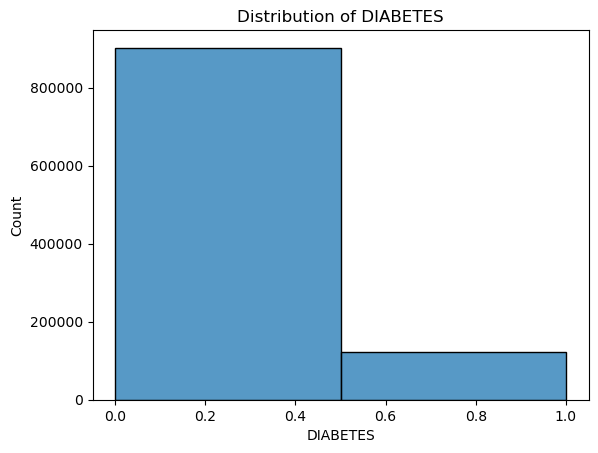

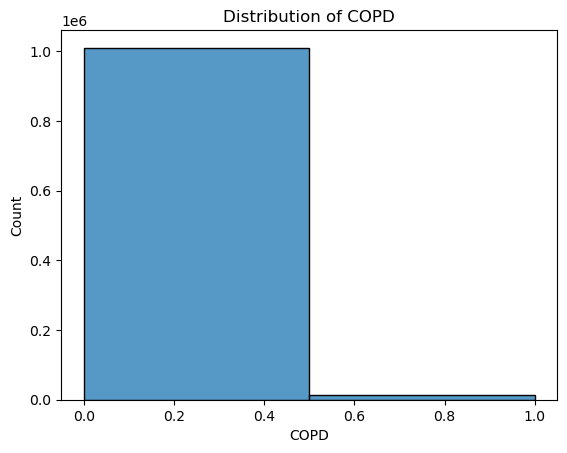

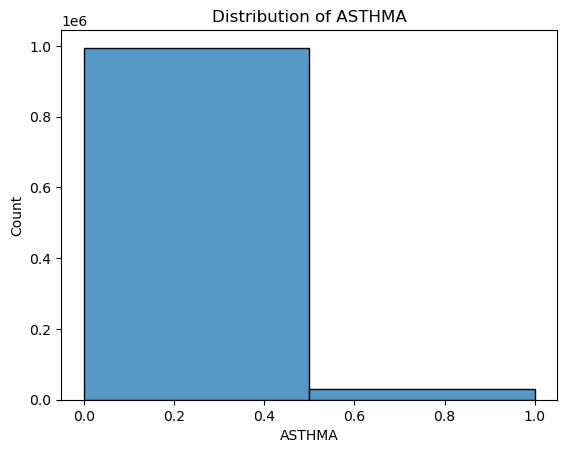

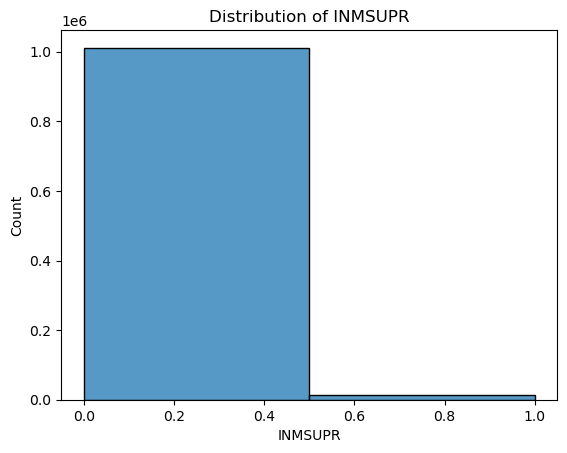

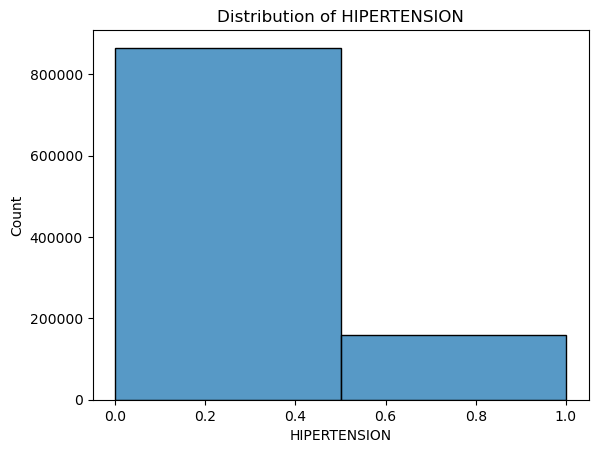

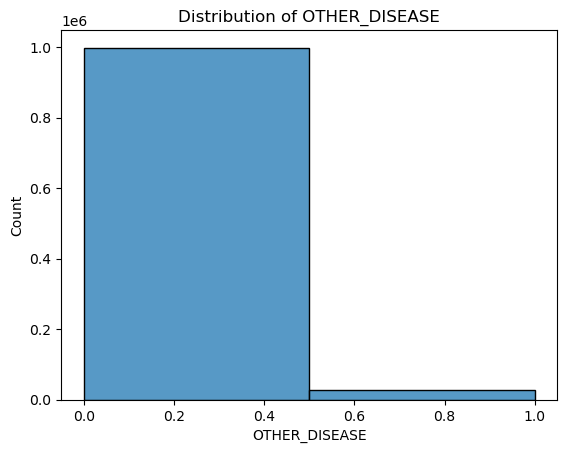

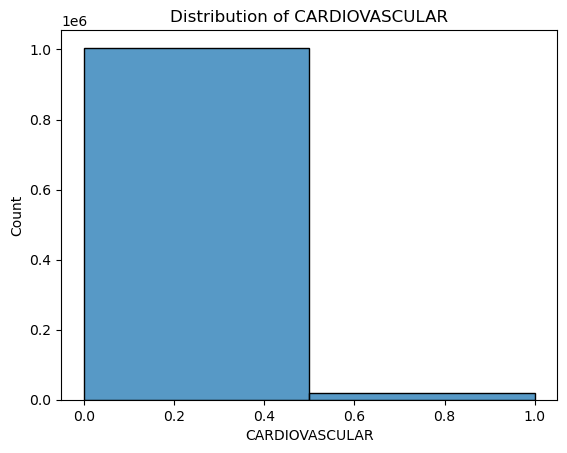

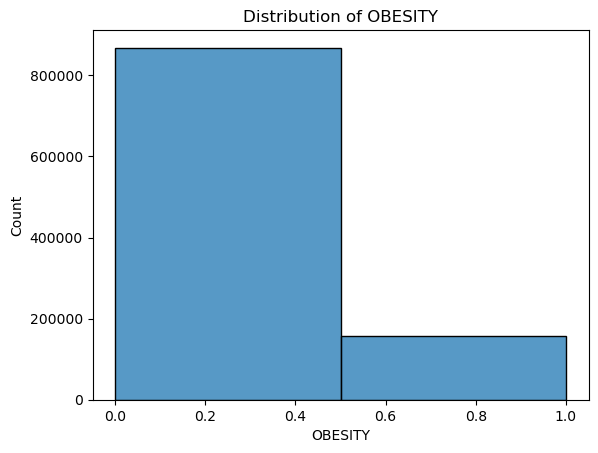

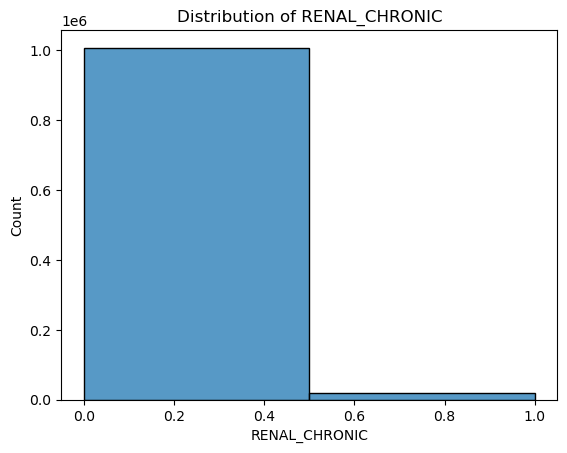

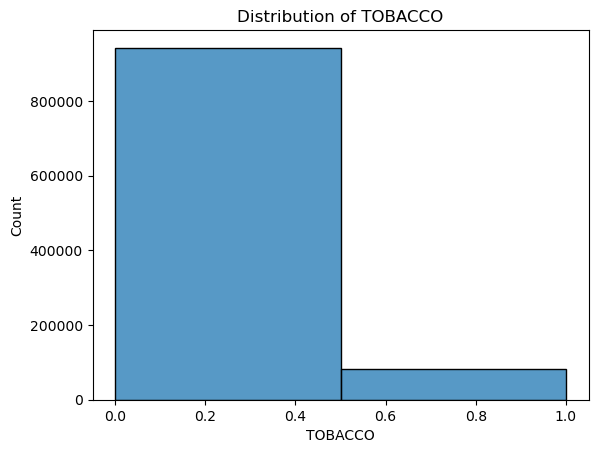

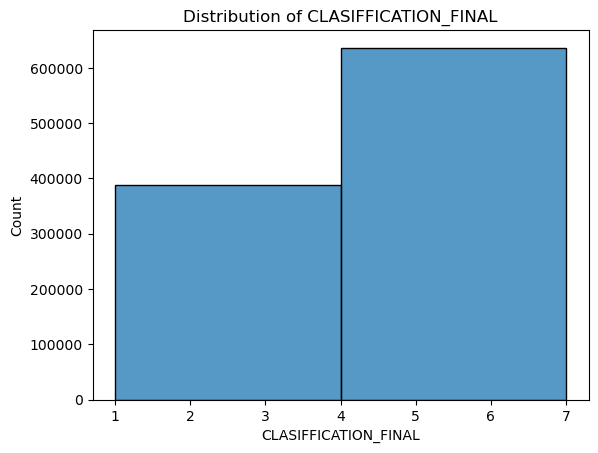

In [25]:
# Plot distributions for remaining features after preprocessing
for col in df.columns:
    if col=="TARGET_DOA" or col=="DATE_DIED" or col=="AGE":
        continue 
    elif col=="CLASSIFICATION_FINAL" or col=="MEDICAL_UNIT":
        sns.histplot(data=df, x=col).set(title='Distribution of ' + str(col))
    else:
        sns.histplot(data=df, x=col, bins=2).set(title='Distribution of ' + str(col))
    plt.show()

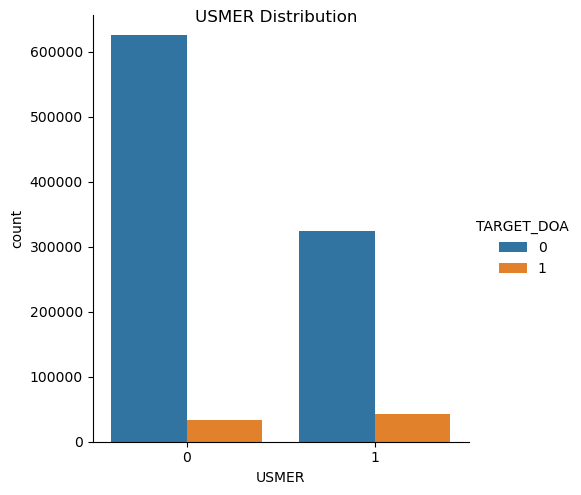

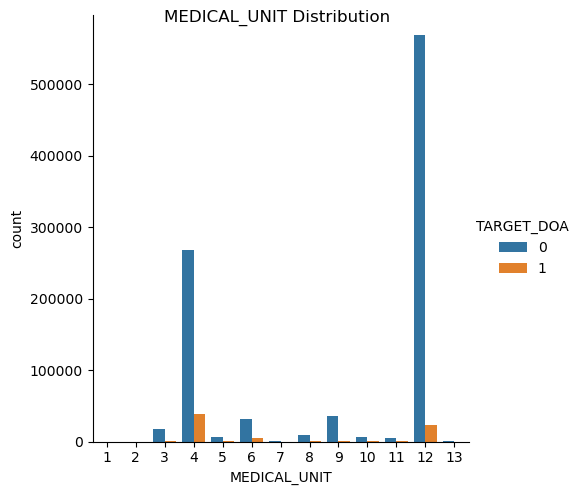

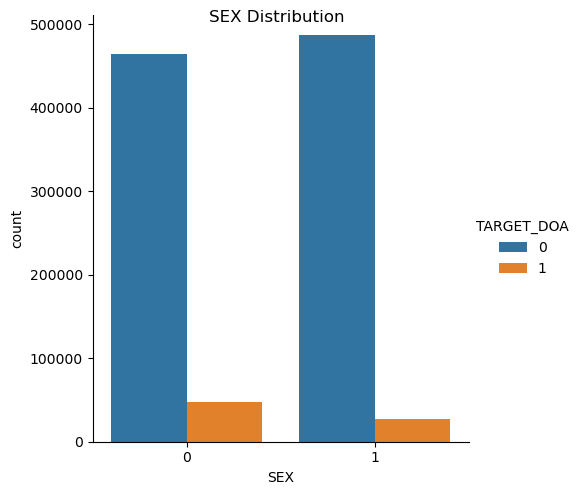

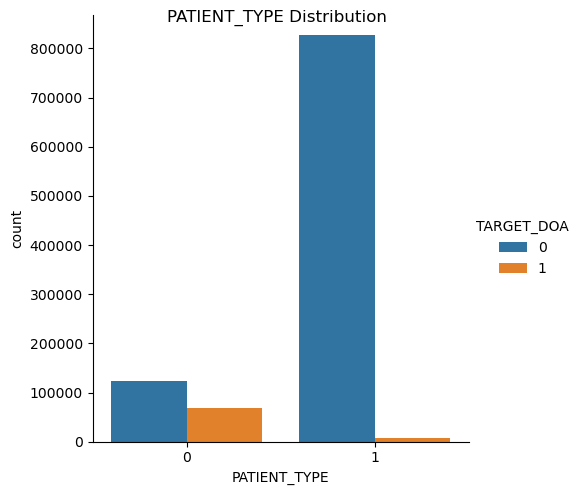

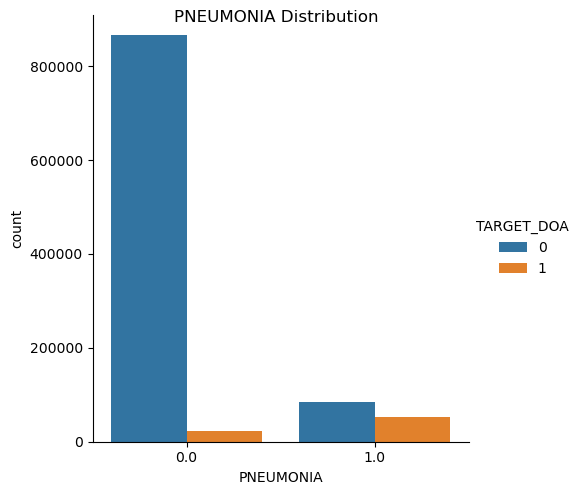

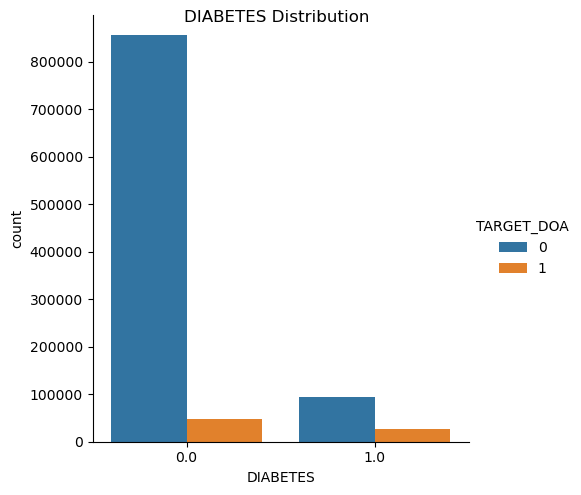

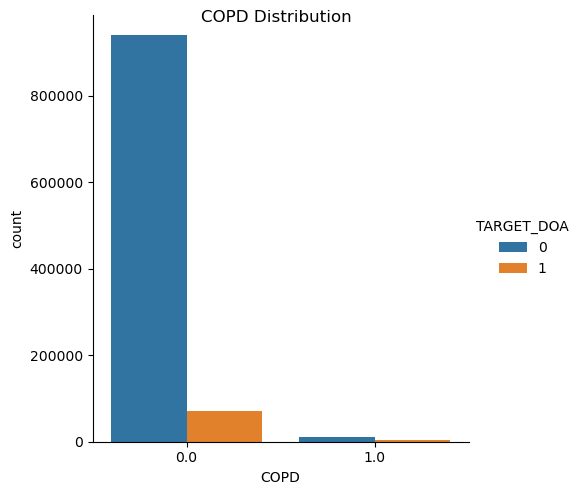

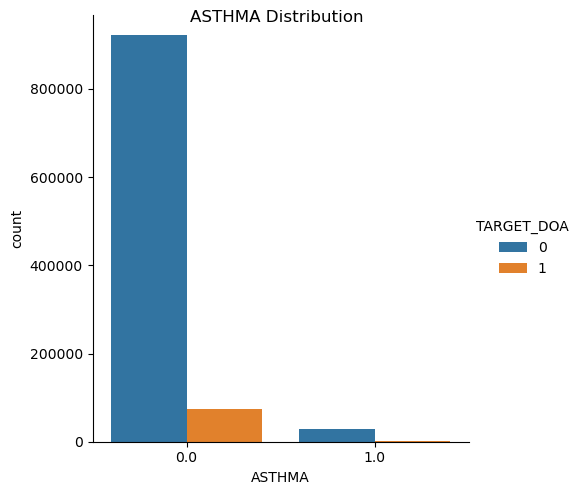

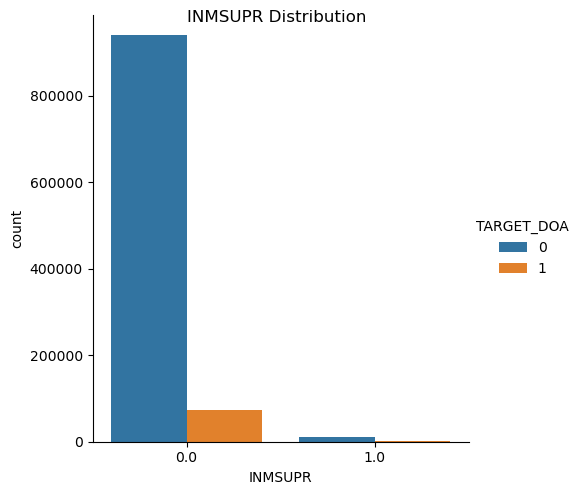

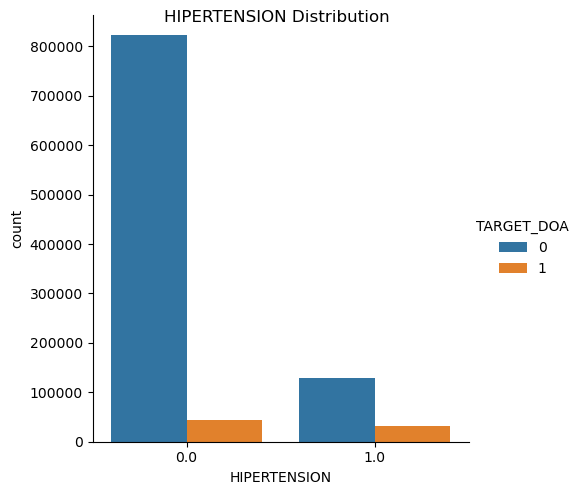

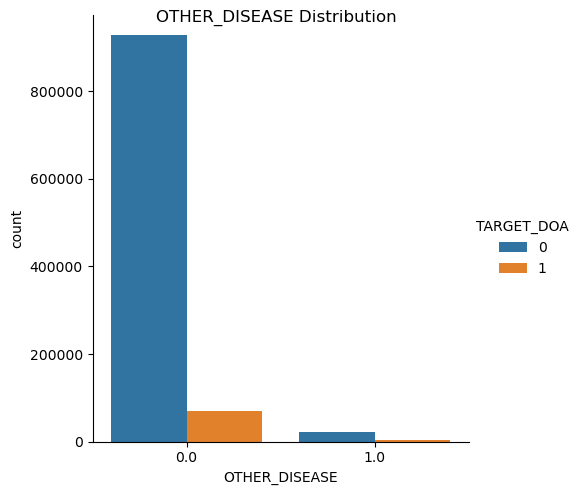

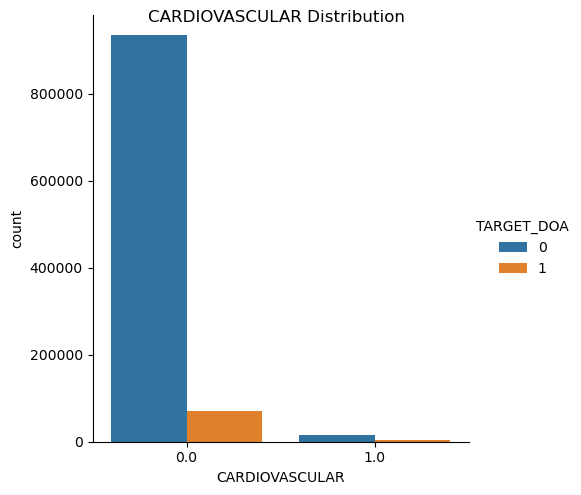

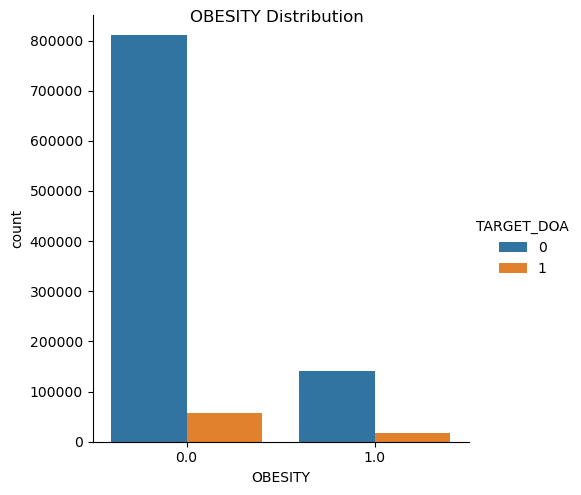

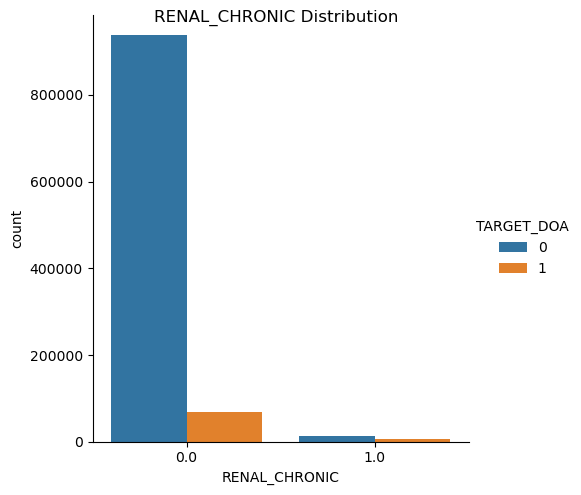

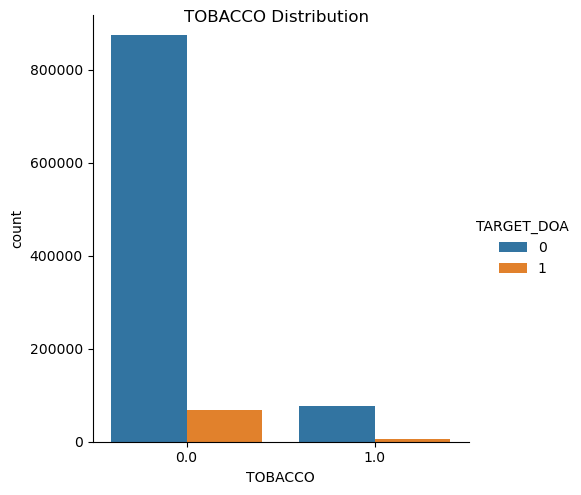

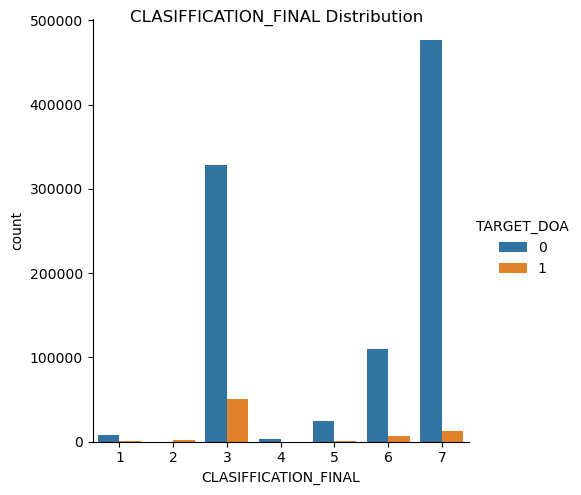

In [26]:
for col in df.columns:
    if col=="TARGET_DOA" or col=="AGE":
        continue
    p=sns.catplot(x=col, hue="TARGET_DOA", data=df, kind='count')
    p.fig.suptitle(col+ " Distribution")

In [27]:
# Split features and target label from dataset.

X = df.drop(columns=["TARGET_DOA"])
y = df["TARGET_DOA"]

# Correlations between Features

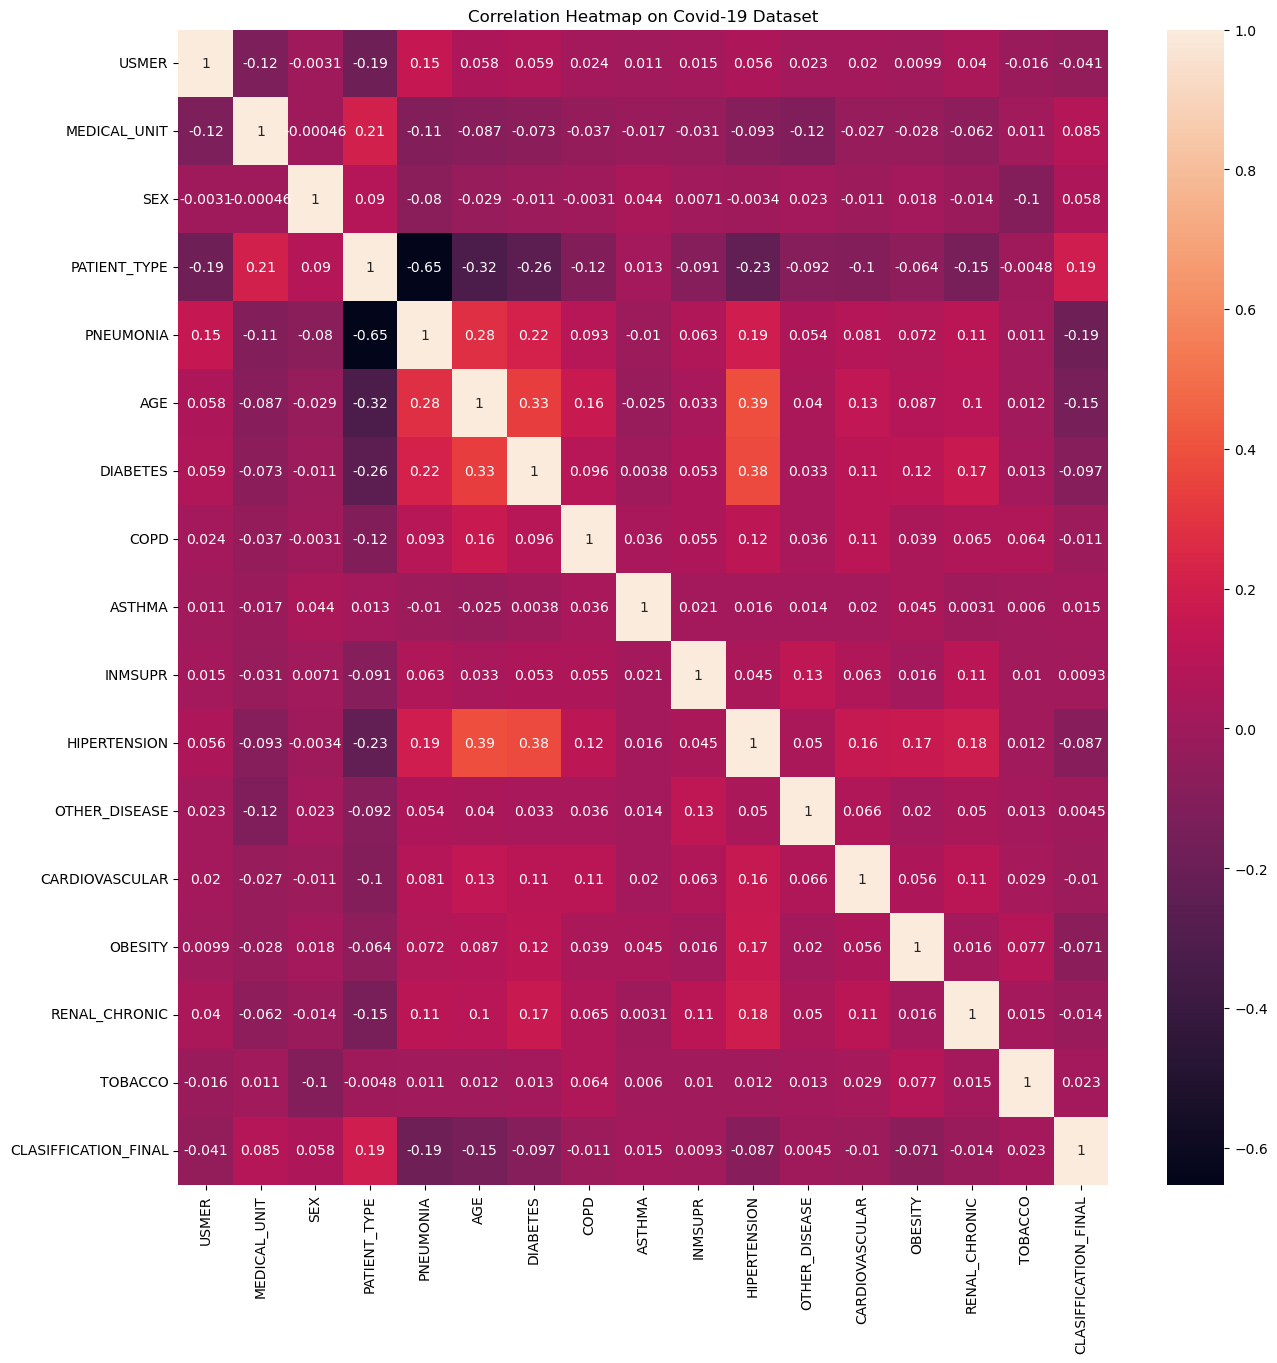

In [28]:
# Plot correlation matrix for the features
corr = X.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True).set_title("Correlation Heatmap on Covid-19 Dataset")
plt.show()

In [29]:
# No features are highly correlated, so we don't need to remove any.
corr_abs = df.corr().abs()
#Source for dropping one of each pair of correlated features:
#https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
upper_half = corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(bool))
drop = [column for column in upper_half.columns if any(upper_half[column] >= 0.9)]
print(drop)

[]


In [30]:
# Print the final shapes of the features and labels.
print("Shape of features set: " + str(X.shape))
print("Shape of labels set: " + str(y.shape))

Shape of features set: (1025152, 17)
Shape of labels set: (1025152,)


# Resampling (Under Sampling / Over Sampling / SMOTE)


**Train/Val/Test Split**

In [31]:
# Original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

**Resampling Strategy**
1. We are going to resample on the train set post split.

In [32]:
# Class distribution before resampling
print('Class distribution before resampling:\n',sorted(Counter(y_train).items()))

Class distribution before resampling:
 [(0, 760350), (1, 59771)]


In [33]:
#Class distribution after random under sampling

rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('Class distribution after random under sampling:\n',sorted(Counter(y_train_rus).items()))

Class distribution after random under sampling:
 [(0, 59771), (1, 59771)]


In [34]:
#Class distribution after random over sampling

ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print('Class distribution after random over sampling:\n',sorted(Counter(y_train_ros).items()))

Class distribution after random over sampling:
 [(0, 760350), (1, 760350)]


In [35]:
#Class distribution after SMOTE

X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
print('Class distribution after SMOTE:\n',sorted(Counter(y_train_smote).items()))

Class distribution after SMOTE:
 [(0, 760350), (1, 760350)]


#  Train and Test (Logistic Regression / Random forest / Gradient boosting / Hyperparameter tuning)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1025152 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMER                 1025152 non-null  int64  
 1   MEDICAL_UNIT          1025152 non-null  int64  
 2   SEX                   1025152 non-null  int64  
 3   PATIENT_TYPE          1025152 non-null  int64  
 4   PNEUMONIA             1025152 non-null  float64
 5   AGE                   1025152 non-null  int64  
 6   DIABETES              1025152 non-null  float64
 7   COPD                  1025152 non-null  float64
 8   ASTHMA                1025152 non-null  float64
 9   INMSUPR               1025152 non-null  float64
 10  HIPERTENSION          1025152 non-null  float64
 11  OTHER_DISEASE         1025152 non-null  float64
 12  CARDIOVASCULAR        1025152 non-null  float64
 13  OBESITY               1025152 non-null  float64
 14  RENAL_CHRONIC         1025152 non-

**Constant Predictor:**

In [37]:
# Baseline constant negative predictor
y_pred = np.array([0] * len(y_test))

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

# Notice that the baseline constant predictor gives 92% accuracy on the original data.
# Accuracy isn't a very good indicator of how well the predictor model is performing due to the highly imbalanced nature 
# of the dataset.
# We are going to use F1 score instead.

Accuracy: 0.9271183382025158
Precision: 0.0
Recall: 0.0
F1 score: 0.0


C:\Users\zixiangloh\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Baseline constant positive predictor
y_pred = np.array([1] * len(y_test))

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

# The baseline F1 value of a constant positive predictor is 0.14. Our model must perform better than this.

Accuracy: 0.07288166179748429
Precision: 0.07288166179748429
Recall: 1.0
F1 score: 0.13586151090583432


In [39]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
predictor_models = []

**Methodology**
1. We are going to run each model once through the 4 train sets (original, ROS, RUS, SMOTE).
2. Pick the best model/dev set combination by using the combination with the highest F1-score on test set.
3. Then we are going to do hyperparameter tuning on that combination.

**Logistic Regression:**

In [40]:
# For logictic regression we will modify the data slightly to add a bias column
X_train_lr = X_train.copy()
X_train_ros_lr = X_train_ros.copy()
X_train_rus_lr = X_train_rus.copy()
X_train_smote_lr = X_train_smote.copy()

if 'Bias' not in X_train_lr:
    X_train_lr.insert(len(X_train_lr.columns), 'Bias', [1] * len(X_train_lr.index))
if 'Bias' not in X_train_ros_lr:
    X_train_ros_lr.insert(len(X_train_ros_lr.columns), 'Bias', [1] * len(X_train_ros_lr.index))
if 'Bias' not in X_train_rus_lr:
    X_train_rus_lr.insert(len(X_train_rus_lr.columns), 'Bias', [1] * len(X_train_rus_lr.index))
if 'Bias' not in X_train_smote_lr:
    X_train_smote_lr.insert(len(X_train_smote_lr.columns), 'Bias', [1] * len(X_train_smote_lr.index))

X_test_lr = X_test.copy()
if 'Bias' not in X_test_lr:
    X_test_lr.insert(len(X_test_lr.columns), 'Bias', [1] * len(X_test_lr.index))

In [41]:
# Logistic Regression with original data

# Initialize the model
lr1 = LogisticRegression(random_state=0, n_jobs=-1)

# Train the model
lr1.fit(X_train_lr, y_train)

# Generate predictions for the test data
y_pred = lr1.predict(X_test_lr)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Logistic Regression Original Data")

Accuracy: 0.9373704464202974
Precision: 0.5956672128163116
Recall: 0.43793080372080573
F1 score: 0.504763006672066


In [42]:
# Logistic Regression with over sampling data

# Initialize the model
lr2 = LogisticRegression(random_state=0, n_jobs=-1)

# Train the model
lr2.fit(X_train_ros_lr, y_train_ros)

# Generate predictions for the test data
y_pred = lr2.predict(X_test_lr)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Logistic Regression ROS Data")

Accuracy: 0.8937136335480976
Precision: 0.40027954922687164
Recall: 0.9198956032925115
F1 score: 0.5578280983686389


In [43]:
# Logistic Regression with under sampling data

# Initialize the model
lr3 = LogisticRegression(random_state=0, n_jobs=-1)

# Train the model
lr3.fit(X_train_rus_lr, y_train_rus)

# Generate predictions for the test data
y_pred = lr3.predict(X_test_lr)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Logistic Regression RUS Data")

Accuracy: 0.8939233579312397
Precision: 0.400827650521653
Recall: 0.9204309710232216
F1 score: 0.5584586962259172


In [44]:
# Logistic Regression with SMOTE data

# Initialize the model
lr4 = LogisticRegression(random_state=0, n_jobs=-1)

# Train the model
lr4.fit(X_train_smote_lr, y_train_smote)

# Generate predictions for the test data
y_pred = lr4.predict(X_test_lr)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Logistic Regression SMOTE Data")

Accuracy: 0.893455136052597
Precision: 0.39798391864727445
Recall: 0.9009569698186441
F1 score: 0.5520903815792172


**Random Forest**

In [45]:
# Random Forest with original data

# Initialize the random forest model with 100 trees
rf1 = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Train the model on the training data
rf1.fit(X_train, y_train)

# Generate predictions for the test data
y_pred = rf1.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Random Forest Original Data")

Accuracy: 0.9341855621832796
Precision: 0.5578443113772455
Recall: 0.46757679180887374
F1 score: 0.5087374399301005


In [46]:
# Random Forest with over sampling data

# Initialize the random forest model with 100 trees
rf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Train the model on the training data
rf2.fit(X_train_ros, y_train_ros)

# Generate predictions for the test data
y_pred = rf2.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Random Forest ROS Data")

Accuracy: 0.9076042159478322
Precision: 0.4236537801015151
Recall: 0.7428896473265074
F1 score: 0.5395907257084528


In [47]:
# Random Forest with under sampling data

# Initialize the random forest model with 100 trees
rf3 = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Train the model on the training data
rf3.fit(X_train_rus, y_train_rus)

# Generate predictions for the test data
y_pred = rf3.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Random Forest RUS Data")

Accuracy: 0.879925474684316
Precision: 0.37023924471623215
Recall: 0.9237770193401593
F1 score: 0.5286154670955636


In [48]:
# Random Forest with SMOTE

# Initialize the random forest model with 100 trees
rf4 = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Train the model on the training data
rf4.fit(X_train_smote, y_train_smote)

# Generate predictions for the test data
y_pred = rf4.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("Random Forest SMOTE Data")

Accuracy: 0.9159053996712693
Precision: 0.45027468962235584
Recall: 0.6965803386200897
F1 score: 0.5469784550709406


**Gradient boosting**

In [49]:
# Gradient boosting with original data

# Initialize the gradient boosting model with 100 estimators
GB1 = xgb.XGBClassifier(n_estimators=100)

# Train the model on the test data
GB1.fit(X_train, y_train)

# Generate predictions for the test data
y_pred = GB1.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("XGBoost Original Data")

Accuracy: 0.9420477878954889
Precision: 0.6366151923591895
Recall: 0.477280331927993
F1 score: 0.545551900864377


In [50]:
# Gradient boosting with over sampling data

# Initialize the gradient boosting model with 100 estimators
GB2 = xgb.XGBClassifier(n_estimators=100)

# Train the model on the training data
GB2.fit(X_train_ros, y_train_ros)

# Generate predictions for the test data
y_pred = GB2.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("XGBoost ROS Data")

Accuracy: 0.8873682516302412
Precision: 0.38842952579126055
Recall: 0.9494077494479021
F1 score: 0.5513047195290186


In [51]:
# Gradient boosting with under sampling data

# Initialize the gradient boosting model with 100 estimators
GB3 = xgb.XGBClassifier(n_estimators=100)

# Train the model on the training data
GB3.fit(X_train_rus, y_train_rus)

# Generate predictions for the test data
y_pred = GB3.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("XGBoost RUS Data")

Accuracy: 0.8842223858831103
Precision: 0.3819811599259279
Recall: 0.9524861138994847
F1 score: 0.5452838862922381


In [52]:
# Gradient boosting with SMOTE data

# Initialize the gradient boosting model with 100 estimators
GB4 = xgb.XGBClassifier(n_estimators=100)

# Train the model on the training data
GB4.fit(X_train_smote, y_train_smote)

# Generate predictions for the test data
y_pred = GB4.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
predictor_models.append("XGBoost SMOTE Data")

Accuracy: 0.910013607698348
Precision: 0.4393902734091459
Recall: 0.85069932409824
F1 score: 0.5794775949309385


In [53]:
model_summary_df = pd.DataFrame.from_dict({"Accuracy": accuracies, "Precision": precisions, "Recall": recalls,
                                           "F1": f1_scores})
model_summary_df.index = predictor_models

print(model_summary_df)

                                   Accuracy  Precision    Recall        F1
Logistic Regression Original Data  0.937370   0.595667  0.437931  0.504763
Logistic Regression ROS Data       0.893714   0.400280  0.919896  0.557828
Logistic Regression RUS Data       0.893923   0.400828  0.920431  0.558459
Logistic Regression SMOTE Data     0.893455   0.397984  0.900957  0.552090
Random Forest Original Data        0.934186   0.557844  0.467577  0.508737
Random Forest ROS Data             0.907604   0.423654  0.742890  0.539591
Random Forest RUS Data             0.879925   0.370239  0.923777  0.528615
Random Forest SMOTE Data           0.915905   0.450275  0.696580  0.546978
XGBoost Original Data              0.942048   0.636615  0.477280  0.545552
XGBoost ROS Data                   0.887368   0.388430  0.949408  0.551305
XGBoost RUS Data                   0.884222   0.381981  0.952486  0.545284
XGBoost SMOTE Data                 0.910014   0.439390  0.850699  0.579478


**Hyperparameter tuning**

The Logistic Regression model with the highest F1 score is LR with RUS Data. We will attempt to tune the hyperparameters for that model.  

In [54]:
# Logistic Regression with original data

# Initialize the model
lr_cv = LogisticRegression(random_state=0, solver='liblinear')

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# Perform grid search with 5-fold cross-validation
grid_search_lr = GridSearchCV(lr_cv, param_grid, cv=5, n_jobs=-1, scoring="f1")
grid_search_lr.fit(X_train_rus_lr, y_train_rus)

# Print the best hyperparameters and corresponding F1
print('Best hyperparameters:', grid_search_lr.best_params_)
print('Best F1:', f1_score(y_test, grid_search_lr.predict(X_test_lr)))

Best hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Best F1: 0.5586551346083566


Random Forest model with the highest F1 score is RF with SMOTE Data. We will attempt to tune the hyperparameters for that model.

In [55]:
# Try to load an existing model
filename = os.path.join(model_root, 'RF_randomcv_model.sav')
try:
    random_search_rf = pkl.load(open(filename, 'rb'))
except FileNotFoundError:
    # Initialize the random forest model
    rf_cv = RandomForestClassifier(bootstrap=True, random_state=0, oob_score=True)

    param_distributions = {'n_estimators': [50, 100, 200],
                           'max_depth': [5, 10, 20],
                           'min_samples_split': [2, 5, 10],
                           'min_samples_leaf': [1, 2, 4],
                           'max_features': ['sqrt', 'log2', None]
                           }

    # Perform random search with 5-fold cross-validation
    random_search_rf = RandomizedSearchCV(rf_cv, param_distributions=param_distributions, cv=5, n_jobs=-1, scoring="f1")
    random_search_rf.fit(X_train_smote, y_train_smote)

    # Save model 
    pkl.dump(random_search_rf, open(filename, 'wb'))

# Print the best hyperparameters and corresponding accuracy
print('Best hyperparameters:', random_search_rf.best_params_)
print('Best F1:', f1_score(y_test, random_search_rf.predict(X_test)))

Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20}
Best F1: 0.5725180255130338


XGBoost model with the highest F1 score is XGB with SMOTE Data. We will attempt to tune the hyperparameters for that model.

In [56]:
# Try to load an existing model
filename = os.path.join(model_root, 'XGB_randomcv_model.sav')
try:
    random_search_xgb = pkl.load(open(filename, 'rb'))
except FileNotFoundError:
    # Initialize the gradient boosting model 
    GB_cv = xgb.XGBClassifier(random_state=0)

    param_distributions = {'n_estimators': [50, 100, 200],
                           'max_depth': [5, 10, 20],
                           'learning_rate': [0.1, 0.01, 0.001],
                           'booster': ['gbtree', 'gblinear', 'dart'],
                           'reg_alpha': [1, 0.1, 0.01, 0.001],
                           'reg_lambda': [1, 0.1, 0.01, 0.001]
                           }

    # Perform grid search with 5-fold cross-validation
    random_search_xgb = RandomizedSearchCV(GB_cv, param_distributions=param_distributions, cv=5, n_jobs=-1, scoring="f1")
    random_search_xgb.fit(X_train_smote, y_train_smote)

    # Save model 
    pkl.dump(random_search_xgb, open(filename, 'wb'))

# Print the best hyperparameters and corresponding accuracy
print('Best hyperparameters:', random_search_xgb.best_params_)
print('Best f1:', f1_score(y_test, random_search_xgb.predict(X_test)))

Best hyperparameters: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.01, 'booster': 'gbtree'}
Best f1: 0.5709301214033075


In [57]:
# Using the best parameters we are going to train a golden model

lr_golden_model = LogisticRegression(random_state=0, solver='liblinear', **grid_search_lr.best_params_)
lr_golden_model.fit(X_train_rus_lr, y_train_rus)

# Generate predictions for the test data
y_pred = lr_golden_model.predict(X_test_lr)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.8939770083548342
Precision: 0.4009792777826353
Recall: 0.9206986548885766
F1 score: 0.5586551346083566


In [58]:
# Try loading the golden RF model
filename = os.path.join(model_root, 'RF_golden_model.sav')
try:
    rf_golden_model = pkl.load(open(filename, 'rb'))
except FileNotFoundError:
    rf_golden_model = RandomForestClassifier(random_state=0, **random_search_rf.best_params_)
    rf_golden_model.fit(X_train_smote, y_train_smote)
    
    pkl.dump(rf_golden_model, open(filename, 'wb'))

# Generate predictions for the test data
y_pred = rf_golden_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.9097794967590267
Precision: 0.4372551096049984
Recall: 0.828950010038145
F1 score: 0.5725180255130338


In [59]:
# Try loading the golden XGB model
filename = os.path.join(model_root, 'XGB_golden_model.sav')
try:
    xgb_golden_model = pkl.load(open(filename, 'rb'))
except FileNotFoundError:
    xgb_golden_model = xgb.XGBClassifier(random_state=0, **random_search_xgb.best_params_)
    xgb_golden_model.fit(X_train_smote, y_train_smote)
    
    pkl.dump(xgb_golden_model, open(filename, 'wb'))

# Generate predictions for the test data
y_pred = xgb_golden_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.912452263316279
Precision: 0.4440724621508016
Recall: 0.7989024961520445
F1 score: 0.570841103619758


Text(0.5, 1.0, 'Random Forest Golden Model Feature Importances')

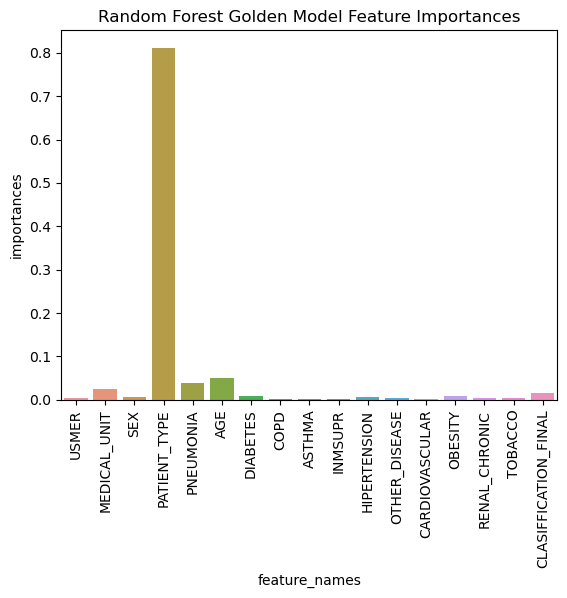

In [60]:
# RF Golden Model Feature Importances
rf_importances_df = pd.DataFrame.from_dict({"feature_names": rf_golden_model.feature_names_in_,
                                            "importances": rf_golden_model.feature_importances_ })
ax = sns.barplot(x=rf_importances_df["feature_names"], y=rf_importances_df["importances"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Random Forest Golden Model Feature Importances")

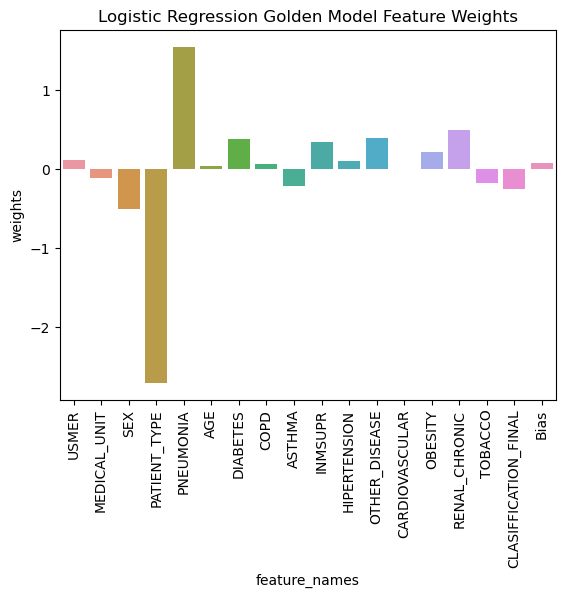

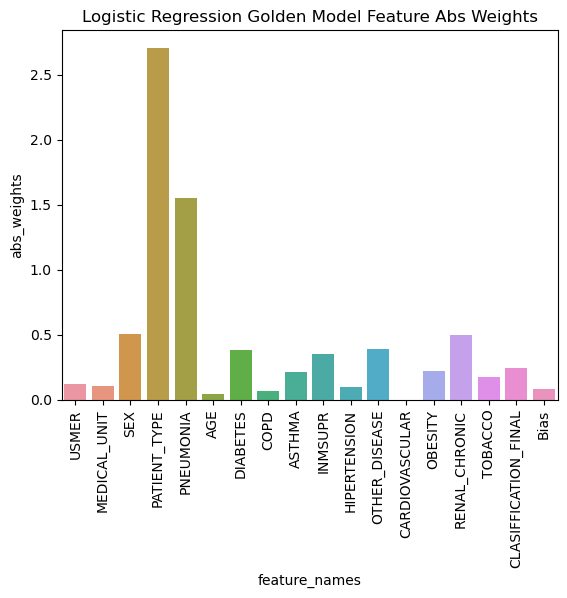

In [63]:
# LR Golden Model Feature Weights
lr_importances_df = pd.DataFrame.from_dict({"feature_names": lr_golden_model.feature_names_in_,
                                            "weights": list(np.squeeze(lr_golden_model.coef_))})
ax = sns.barplot(x=lr_importances_df["feature_names"], y=lr_importances_df["weights"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Logistic Regression Golden Model Feature Weights")
plt.show()

lr_importances_df = pd.DataFrame.from_dict({"feature_names": lr_golden_model.feature_names_in_,
                                            "abs_weights": list(np.abs(np.squeeze(lr_golden_model.coef_)))})
ax = sns.barplot(x=lr_importances_df["feature_names"], y=lr_importances_df["abs_weights"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Logistic Regression Golden Model Feature Abs Weights")
plt.show()

Text(0.5, 1.0, 'XGBoost Golden Model Feature Importances')

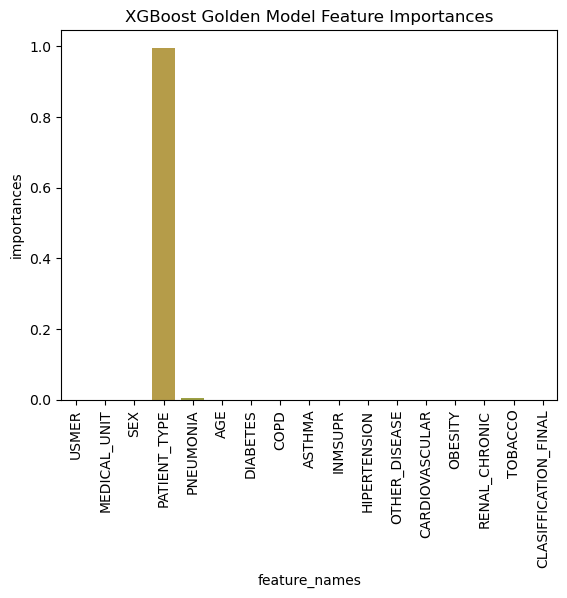

In [64]:
# XGB Golden Model Feature Importances
xgb_importances_df = pd.DataFrame.from_dict({"feature_names": xgb_golden_model.feature_names_in_,
                                            "importances": xgb_golden_model.feature_importances_ })
ax = sns.barplot(x=xgb_importances_df["feature_names"], y=xgb_importances_df["importances"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("XGBoost Golden Model Feature Importances")